# FIT5202 Data processing for Big Data
# Assignment 2A:
### Analysing Flight-delays Data (Preprocessing, Visualization, Data Modelling)

Student Name: PEIYU LIU
<br>Student ID: 31153291

# 1 Data Loading, Cleaning, Labelling, and Exploration

## 1.1 Data loading

#### 1.1.1 create SparkSession

In [1]:
# import libraries  that assignment nended.
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import pandas as pd

# do file literated
# create a SparkContext object using SparkSession
master = 'local[*]'
app_name = '31153291_Ass1'
# build a SparkConf
spark_conf = SparkConf().setMaster(master).setAppName(app_name)
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

#### 1.1.2 Read the 20 files of “flight*.csv” flightsRawDf

Reference: list all files:https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory
<br>Literate all flight files in flight folder. Add files' names with files' path into list

In [2]:
import os

file_path = './flight-delays/'
files = os.listdir(file_path)
file_container = []
for file in files:
    if file.startswith('flight'):  # need all “flight*.csv” files
        file_container.append('./flight-delays/' + file)

        
# read data with both header and inferSchema attributes are set to True
flightsRawDf = spark.read.format('csv').option('header', True).option('inferSchema', True).load('flight-delays/flight1.csv')
# total number of flightsRawDf rows
flightsRawDf.count()

28940

#### 1.1.3 list of columns from flightsRawDf

In [3]:
allColumnFlights = flightsRawDf.columns
allColumnFlights

['YEAR',
 'MONTH',
 'DAY',
 'DAY_OF_WEEK',
 'AIRLINE',
 'FLIGHT_NUMBER',
 'TAIL_NUMBER',
 'ORIGIN_AIRPORT',
 'DESTINATION_AIRPORT',
 'SCHEDULED_DEPARTURE',
 'DEPARTURE_TIME',
 'DEPARTURE_DELAY',
 'TAXI_OUT',
 'WHEELS_OFF',
 'SCHEDULED_TIME',
 'ELAPSED_TIME',
 'AIR_TIME',
 'DISTANCE',
 'WHEELS_ON',
 'TAXI_IN',
 'SCHEDULED_ARRIVAL',
 'ARRIVAL_TIME',
 'ARRIVAL_DELAY',
 'DIVERTED',
 'CANCELLED',
 'CANCELLATION_REASON',
 'AIR_SYSTEM_DELAY',
 'SECURITY_DELAY',
 'AIRLINE_DELAY',
 'LATE_AIRCRAFT_DELAY',
 'WEATHER_DELAY']

## 1.2 Data cleaning

#### 1.2.1 display the number of missing values for each column.
Reference: find Null and Nan values:<br>https://stackoverflow.com/questions/44627386/how-to-find-count-of-null-and-nan-values-for-each-column-in-a-pyspark-dataframe

In [4]:
from pyspark.sql.functions import isnan, when, count, col


def count_missings(df, sort=True):
    df = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()
    if len(df) == 0:
        return None
    if sort:
        return df.rename(index={0: 'count'}).T.sort_values('count', ascending=False)
    return df

In [5]:
count_missings(flightsRawDf)

,count
CANCELLATION_REASON,28498
WEATHER_DELAY,23781
LATE_AIRCRAFT_DELAY,23781
AIRLINE_DELAY,23781
SECURITY_DELAY,23781
AIR_SYSTEM_DELAY,23781
AIR_TIME,508
ARRIVAL_DELAY,508
ELAPSED_TIME,508
WHEELS_ON,454


#### missing completely at random?

Report(200 words)

#### 1.2.2 
- obtain the column names whose number of missing values is greater x percent
- removing columns listed in removedColumns variable
- Drop rows with Null and Nan values from flightsRawDf
Reference: find percentage: https://stackoverflow.com/questions/51070985/find-out-the-percentage-of-missing-values-in-each-column-in-the-given-dataset<br>

In [6]:
#Reference: find percentage: https://stackoverflow.com/questions/51070985/find-out-the-percentage-of-missing-values-in-each-column-in-the-given-dataset<br>
def find_removed_columns(x, df):
    missingColumns = count_missings(df)
    thresholdLevel = df.count() * x / 100
    thresholdColumns = missingColumns[missingColumns['count'] > thresholdLevel]
    return list(thresholdColumns.index)

# drop columns
def eliminate_columns(x, df):
    dropColumns = find_removed_columns(x, df)
    newDf = df.drop(*dropColumns)
    return newDf


# drop rows
def eliminate_rows(df):
    df = df.na.drop(how='any')
    return df


# display details
def print_rows_columns(df):
    columns = df.columns
    print(f'number of columns:{len(columns)},number of rows:{df.count()}')


In [7]:
# a: obtain the column names for all columns in flightsRawDf whose number of missing values is greater 10 percent
find_removed_columns(10,flightsRawDf)

['CANCELLATION_REASON',
 'WEATHER_DELAY',
 'LATE_AIRCRAFT_DELAY',
 'AIRLINE_DELAY',
 'SECURITY_DELAY',
 'AIR_SYSTEM_DELAY']

In [8]:
# b: drop columns and drop rows
flightsDf = eliminate_rows(eliminate_columns(10, flightsRawDf))
flightsDf_ = flightsDf
print_rows_columns(flightsRawDf)
line = '-'*50
print(line)
print('dislay the number of rows and columns flightsDf') 
print_rows_columns(flightsDf)

number of columns:31,number of rows:28940
--------------------------------------------------
dislay the number of rows and columns flightsDf
number of columns:25,number of rows:28432


# 1.3 Data Labelling

#### 1.3.1 
- Generate labels in <strong>flightsDf</strong>,new column names are <code>binaryArrDelay and binaryDeptDelay</code>
<br>Reference: when/otherwise and multiple conditions:<br>https://sparkbyexamples.com/pyspark/pyspark-when-otherwise/

In [9]:
from pyspark.sql.functions import isnan, when, count, col

flightsDf = flightsDf.withColumn('binaryArrDelay', when(col('ARRIVAL_DELAY') >= 0, 1).otherwise(0))
flightsDf = flightsDf.withColumn('binaryDeptDelay', when(col('DEPARTURE_DELAY') >= 0, 1).otherwise(0))

- new column names are <code>multiClassArrDelay and multiCassDeptDelay</code>
<br>Reference: Use parentheses to enforce the desired operator precedence<br>https://stackoverflow.com/questions/33151861/how-do-i-use-multiple-conditions-with-pyspark-sql-functions-when
  - below 5 is early
  - 5 to 20 is on time
  - above 20 is late

In [10]:
# https://stackoverflow.com/questions/33151861/how-do-i-use-multiple-conditions-with-pyspark-sql-functions-when
# Use parentheses to enforce the desired operator precedence
flightsDf = flightsDf.withColumn('multiClassArrDelay',
                                   when(col('ARRIVAL_DELAY') < 5, 'early')
                                   .when(col('ARRIVAL_DELAY') > 20, 'late')
                                   .when((col('ARRIVAL_DELAY') <= 20) & (col('ARRIVAL_DELAY') >= 5), 'on time'))

flightsDf = flightsDf.withColumn('multiCassDeptDelay',
                                   when(col('DEPARTURE_DELAY') < 5, 'early')
                                   .when(col('DEPARTURE_DELAY') > 20, 'late')
                                   .when((col('DEPARTURE_DELAY') <= 20) & (col('ARRIVAL_DELAY') >= 5), 'on time'))

#### 1.3.2 Auto labelling flightsDf using function<br>
 [:0] : early<br>
 [0:40]: on time<br>
 [40,1670]: late<br>
Reference: https://stackoverflow.com/questions/39655880/how-to-divide-a-numerical-columns-in-ranges-and-assign-labels-for-each-range-in<br>
https://stackoverflow.com/questions/46225587/how-to-bin-in-pyspark

In [11]:
# show values distributions
columns_ = ['DEPARTURE_DELAY','ARRIVAL_DELAY']
flightsDf.select(columns_).describe().show()

+-------+------------------+------------------+
|summary|   DEPARTURE_DELAY|     ARRIVAL_DELAY|
+-------+------------------+------------------+
|  count|             28432|             28432|
|   mean| 8.965602138435566| 4.085431907709623|
| stddev|36.579469042704936|38.888910363082076|
|    min|               -26|               -70|
|    max|              1046|              1042|
+-------+------------------+------------------+



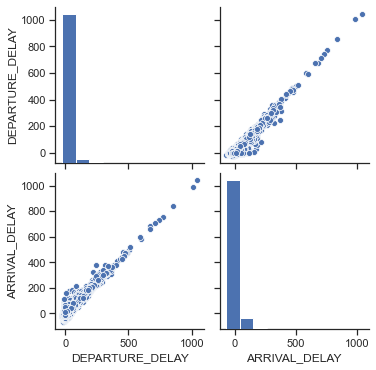

In [12]:
# Scatter chart showing data distribution
import seaborn as sns
sns.set(style = 'ticks')
sns.pairplot(flightsDf.select(columns_).toPandas())
plt.show()

In [13]:
# https://stackoverflow.com/questions/39655880/how-to-divide-a-numerical-columns-in-ranges-and-assign-labels-for-each-range-in
from pyspark.ml.feature import Bucketizer
from pyspark.sql.functions import array,col,lit
splits = [float('-inf'),0,40,1670,float('inf')]
labels = ['early','on time','late']
def auto_label(df,column_,label_):
    bucketizer = Bucketizer(splits = splits, inputCol = column_,outputCol='split')
    with_split = bucketizer.transform(df)
    label_array = array(*(lit(label) for label in labels))
    with_split = with_split.withColumn('AUTO_LABEL',label_array.getItem(col('split').cast('integer')))
    nowith_split = with_split.drop('split')
    output_df = nowith_split.withColumnRenamed('AUTO_LABEL',label_)
    return output_df

In [14]:
labelled_arr = auto_label(flightsDf_,'ARRIVAL_DELAY','multiClassArrDelay')
labelled_dep = auto_label(flightsDf_,'DEPARTURE_DELAY','multiCassDeptDelay')
labelled_arr.printSchema()
labelled_dep.printSchema()

root
 |-- YEAR: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- FLIGHT_NUMBER: integer (nullable = true)
 |-- TAIL_NUMBER: string (nullable = true)
 |-- ORIGIN_AIRPORT: string (nullable = true)
 |-- DESTINATION_AIRPORT: string (nullable = true)
 |-- SCHEDULED_DEPARTURE: integer (nullable = true)
 |-- DEPARTURE_TIME: integer (nullable = true)
 |-- DEPARTURE_DELAY: integer (nullable = true)
 |-- TAXI_OUT: integer (nullable = true)
 |-- WHEELS_OFF: integer (nullable = true)
 |-- SCHEDULED_TIME: integer (nullable = true)
 |-- ELAPSED_TIME: integer (nullable = true)
 |-- AIR_TIME: integer (nullable = true)
 |-- DISTANCE: integer (nullable = true)
 |-- WHEELS_ON: integer (nullable = true)
 |-- TAXI_IN: integer (nullable = true)
 |-- SCHEDULED_ARRIVAL: integer (nullable = true)
 |-- ARRIVAL_TIME: integer (nullable = true)
 |-- ARRIVAL_DELAY: integer (null

#### choice of bin size
- [0,40,1670]

<code>Analysis:</code>In the previous operation, I deleted the default value in the filtered data, and the rows and columns with null values have been filtered out, so there is no need to supplement the default values of the data. Use describe function to print out the departure delay, a summary of the data for arrival. You can see that the smallest departure_delay is -48, and the arrival_delay is -82. You can set the negative range without setting it individually but only put the numbers less than or equal to 0 to be the carrier arrival. The maximum values are 1670 and 1665, and the maximum value can be set to late. Select the integer around the standard variance as the standard 40—Set 0,40 to on time, 40,1670 to late, and 0 as early. The linear regression graph of the departure and arrival delays can be seen from the plot out, and there is no value for out of boundary. So this choice can be used to calculate the entire data.

# 1.4 Data Exploration / Exploratory Analysis

In [15]:
# get integer columns
def int_columns(df):
    int_columns = []
    for column in flightsDf.dtypes:
        if column[1] == 'int':
            int_columns.append(column[0])
    return int_columns

# get string columns
def str_columns(df):
    str_columns = []
    for column in flightsDf.dtypes:
        if column[1] == 'string':
            str_columns.append(column[0])
    return str_columns

# get all columns
def find_columns(df):
    columns_ = []
    for column in flightsDf.dtypes:
        columns_.append(column[0])
    return columns_

#### 1.4.1 basic statistics (count mean stdev, min, max, 25 and 75 percentile)

In [16]:
# basic statistics (count mean stdev, min, max, 25 and 75 percentile)
basic_statistics = flightsDf.select(find_columns(flightsDf)).summary().toPandas()
basic_statistics

,summary,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,...,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,binaryArrDelay,binaryDeptDelay,multiClassArrDelay,multiCassDeptDelay
0,count,28432,28432,28432,28432,28432,28432,28432,28432,28432,...,28432,28432,28432,28432,28432,28432,28432,28432,28432,26477
1,mean,2015.0,6.542522509848059,15.78088069780529,3.9396102982554866,None,2154.5035523353968,None,12657.447693574959,12703.269357495881,...,7.4294808666291505,1499.8384214969049,1483.3540728756332,4.085431907709623,0.0,0.0,0.38249155880697805,0.4248030388294879,None,None
2,stddev,0.0,3.403051585836884,8.807691198397423,1.988883591276028,None,1741.9814025727787,None,1537.5899527964848,1522.7615982081436,...,5.5740641645127305,504.4549109597285,523.3626555510383,38.888910363082076,0.0,0.0,0.48600419112573584,0.49432176905478503,None,None
3,min,2015,1,1,1,AA,1,7819A,10135,10136,...,1,1,1,-70,0,0,0,0,early,early
4,25%,2015,4,8,2,None,743,None,11292.0,11292.0,...,4,1113,1103,-13,0,0,0,0,None,None
5,50%,2015,7,16,4,None,1680,None,12889.0,12892.0,...,6,1523,1516,-5,0,0,0,0,None,None
6,75%,2015,9,23,6,None,3197,None,13930.0,14027.0,...,9,1920,1920,7,0,0,1,1,None,None
7,max,2015,12,31,7,WN,7438,N9EAMQ,YUM,YUM,...,155,2359,2400,1042,0,0,1,1,on time,on time


In [17]:
# only numerial columns
numerial_statistics = flightsDf.select(int_columns(flightsDf)).summary().toPandas()
numerial_statistics

,summary,YEAR,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,...,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,binaryArrDelay,binaryDeptDelay
0,count,28432,28432,28432,28432,28432,28432,28432,28432,28432,...,28432,28432,28432,28432,28432,28432,28432,28432,28432,28432
1,mean,2015.0,6.542522509848059,15.78088069780529,3.9396102982554866,2154.5035523353968,1330.1050576814857,1336.0670019696117,8.965602138435566,16.016495498030388,...,829.2471862689927,1477.9532920652784,7.4294808666291505,1499.8384214969049,1483.3540728756332,4.085431907709623,0.0,0.0,0.38249155880697805,0.4248030388294879
2,stddev,0.0,3.403051585836884,8.807691198397423,1.988883591276028,1741.9814025727787,483.42889884180653,495.7237817482996,36.579469042704936,8.751368270818874,...,610.5286182680387,519.5209861106542,5.5740641645127305,504.4549109597285,523.3626555510383,38.888910363082076,0.0,0.0,0.48600419112573584,0.49432176905478503
3,min,2015,1,1,1,1,5,1,-26,1,...,31,1,1,1,1,-70,0,0,0,0
4,25%,2015,4,8,2,743,918,922,-5,11,...,377,1059,4,1113,1103,-13,0,0,0,0
5,50%,2015,7,16,4,1680,1325,1331,-2,14,...,651,1512,6,1523,1516,-5,0,0,0,0
6,75%,2015,9,23,6,3197,1730,1742,7,19,...,1069,1914,9,1920,1920,7,0,0,1,1
7,max,2015,12,31,7,7438,2359,2400,1046,152,...,4983,2400,155,2359,2400,1042,0,0,1,1


#### 1.4.2 categorical columns identify total unique categories
Reference: count distinct:https://www.geeksforgeeks.org/pyspark-count-distinct-from-dataframe/

In [18]:
# categorical columns identify

def count_column_unique(df):
    for column in find_columns(df):
         print(f'column name: {column}, unique identities: {df.select(column).distinct().count()}')

In [19]:
# show categories
count_column_unique(flightsDf)

column name: YEAR, unique identities: 1
column name: MONTH, unique identities: 12
column name: DAY, unique identities: 31
column name: DAY_OF_WEEK, unique identities: 7
column name: AIRLINE, unique identities: 14
column name: FLIGHT_NUMBER, unique identities: 5741
column name: TAIL_NUMBER, unique identities: 4409
column name: ORIGIN_AIRPORT, unique identities: 506
column name: DESTINATION_AIRPORT, unique identities: 504
column name: SCHEDULED_DEPARTURE, unique identities: 1144
column name: DEPARTURE_TIME, unique identities: 1247
column name: DEPARTURE_DELAY, unique identities: 342
column name: TAXI_OUT, unique identities: 109
column name: WHEELS_OFF, unique identities: 1259
column name: SCHEDULED_TIME, unique identities: 422
column name: ELAPSED_TIME, unique identities: 440
column name: AIR_TIME, unique identities: 421
column name: DISTANCE, unique identities: 1249
column name: WHEELS_ON, unique identities: 1321
column name: TAXI_IN, unique identities: 79
column name: SCHEDULED_ARRIVAL

#### 1.4.3 histogram
Reference: https://www.geeksforgeeks.org/plotting-histogram-in-python-using-matplotlib/<br>
a. Percentage of flights that arrive late each month<br>
b. Percentage of flights that arrive late each day of week<br>
c. Percentage of delayed flights by airline

[Text(0.5, 0, 'AIRLINE'),
 Text(0.5, 1.0, 'Percentage of delayed flights by airline')]

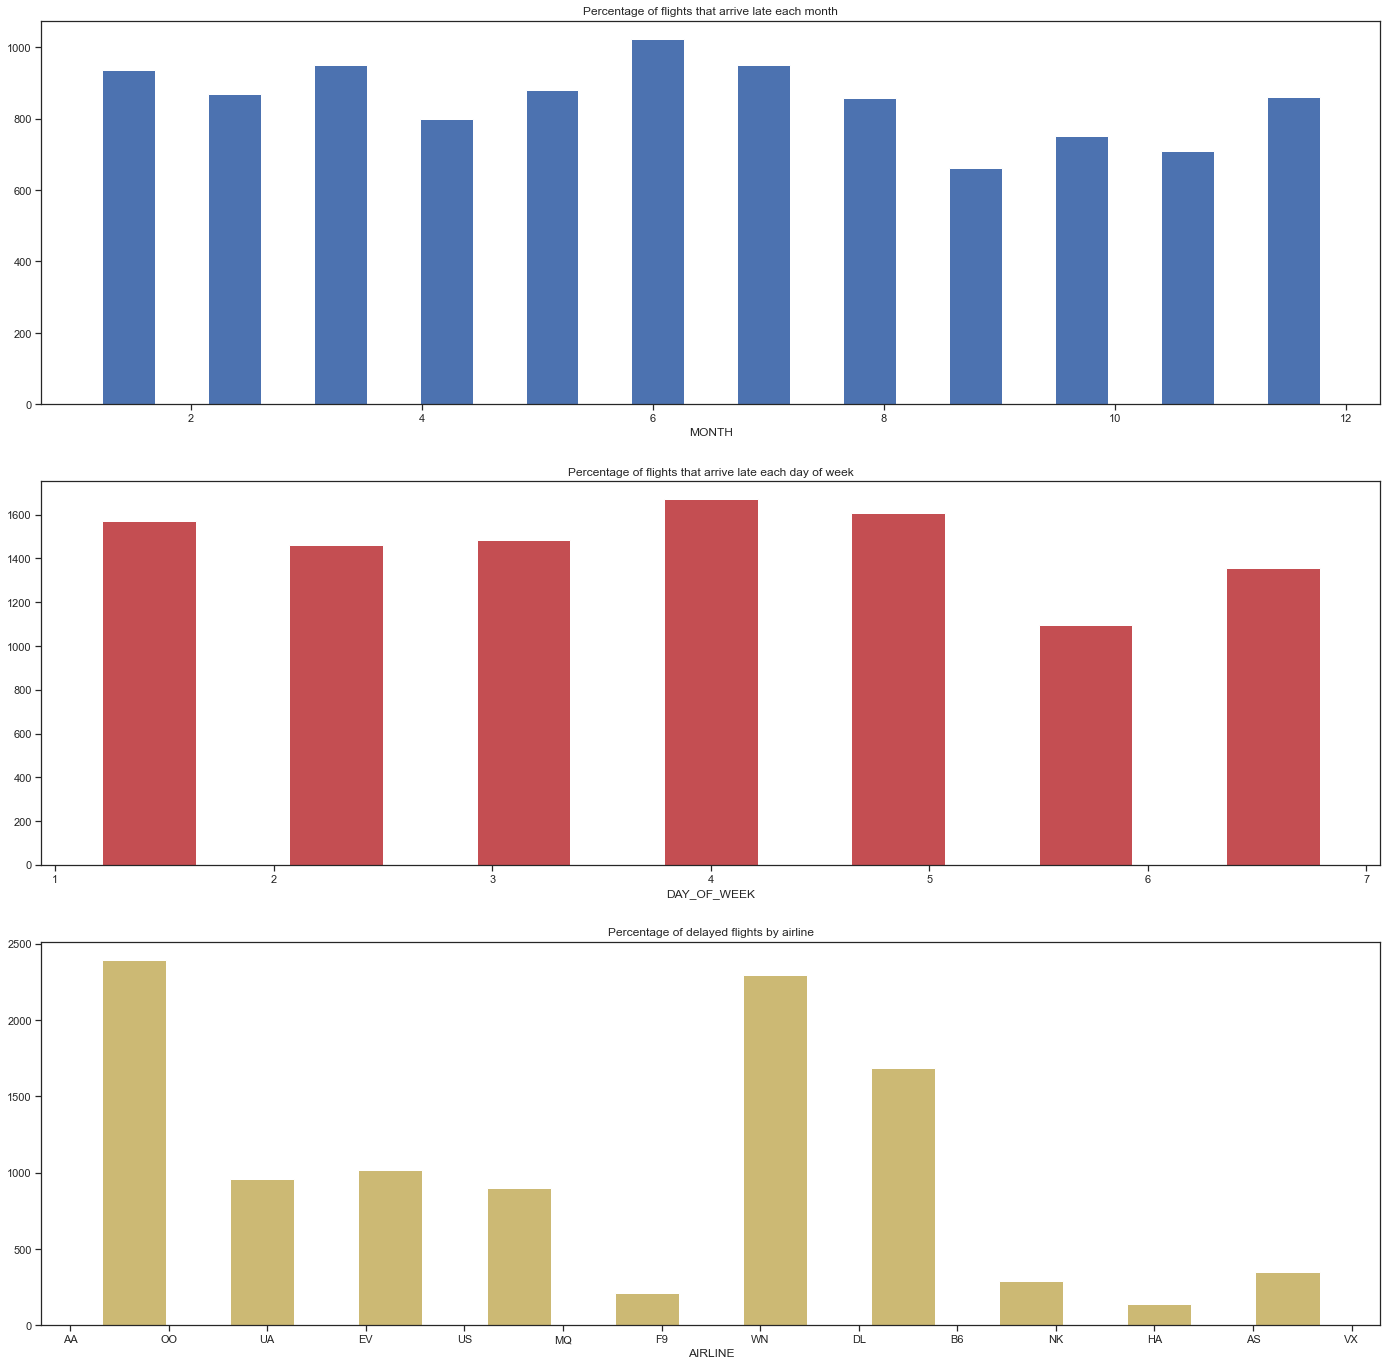

In [20]:
import matplotlib.pyplot as plt
data = flightsDf.toPandas()
fig,(histogramA,histogramB,histogramC) = plt.subplots(3,1,figsize = (24,24))
delay_month = data.loc[data.ARRIVAL_DELAY > 0,'MONTH']
delay_day = data.loc[data.ARRIVAL_DELAY > 0,'DAY_OF_WEEK']
delay_airline = data.loc[data.ARRIVAL_DELAY > 0,'AIRLINE']
histogramA.hist(delay_month,bins = 12, color = 'b', rwidth = 0.5)
histogramB.hist(delay_day,bins = 7, color = 'r',rwidth = 0.5)
histogramC.hist(delay_airline, color = 'y',rwidth = 0.5)
histogramA.set(title = 'Percentage of flights that arrive late each month', xlabel = 'MONTH')
histogramB.set(title = 'Percentage of flights that arrive late each day of week', xlabel = 'DAY_OF_WEEK')
histogramC.set(title = 'Percentage of delayed flights by airline', xlabel = 'AIRLINE')

# 2 Feature extraction and ML Training

Reference: correlation <br>https://stackoverflow.com/questions/52214404/how-to-get-the-correlation-matrix-of-a-pyspark-data-frame<br>https://stackoverflow.com/questions/51831874/how-to-get-correlation-matrix-values-pyspark

In [21]:
# show summary of flightsDf dataframe, stddev for some columns are None or very small, it means low/no feature.
basic_statistics

,summary,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,...,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,binaryArrDelay,binaryDeptDelay,multiClassArrDelay,multiCassDeptDelay
0,count,28432,28432,28432,28432,28432,28432,28432,28432,28432,...,28432,28432,28432,28432,28432,28432,28432,28432,28432,26477
1,mean,2015.0,6.542522509848059,15.78088069780529,3.9396102982554866,None,2154.5035523353968,None,12657.447693574959,12703.269357495881,...,7.4294808666291505,1499.8384214969049,1483.3540728756332,4.085431907709623,0.0,0.0,0.38249155880697805,0.4248030388294879,None,None
2,stddev,0.0,3.403051585836884,8.807691198397423,1.988883591276028,None,1741.9814025727787,None,1537.5899527964848,1522.7615982081436,...,5.5740641645127305,504.4549109597285,523.3626555510383,38.888910363082076,0.0,0.0,0.48600419112573584,0.49432176905478503,None,None
3,min,2015,1,1,1,AA,1,7819A,10135,10136,...,1,1,1,-70,0,0,0,0,early,early
4,25%,2015,4,8,2,None,743,None,11292.0,11292.0,...,4,1113,1103,-13,0,0,0,0,None,None
5,50%,2015,7,16,4,None,1680,None,12889.0,12892.0,...,6,1523,1516,-5,0,0,0,0,None,None
6,75%,2015,9,23,6,None,3197,None,13930.0,14027.0,...,9,1920,1920,7,0,0,1,1,None,None
7,max,2015,12,31,7,WN,7438,N9EAMQ,YUM,YUM,...,155,2359,2400,1042,0,0,1,1,on time,on time


#### design a function to generate correlation for dataframe
- set feature column as vector column
- set inputCols(which columns are used to calculate features
- use data to fit assembler model
- correlate data and features
- return result

Reference: https://stackoverflow.com/questions/52214404/how-to-get-the-correlation-matrix-of-a-pyspark-data-frame
<br>https://stackoverflow.com/questions/51831874/how-to-get-correlation-matrix-values-pyspark

In [22]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

def correlation_matrix(df, corr_columns, method='pearson'):
    # convert to vector column first
    vector_col ="corr_features"
    assembler = VectorAssembler(inputCols=corr_columns, outputCol=vector_col)
    df_vector = assembler.transform(df).select(vector_col)
    # get correlation matrix
    matrix = Correlation.corr(df_vector, vector_col, method)
    result = matrix.collect()[0]["pearson({})".format(vector_col)].values
    # reshape result as dataframe with columns' names
    return pd.DataFrame(result.reshape(-1, len(corr_columns)), columns=corr_columns, index=corr_columns)

#### 2.1.1 Discuss the feature selection and prepare the feature columns

In [23]:
# use function int_columns get all integer columns to do correlation
intColumns = int_columns(flightsDf)
flightsDf_original = flightsDf.select([*intColumns])

In [24]:
# show correlation table for original flightsDf datafame
correlation_matrix(flightsDf_original, flightsDf_original.columns)

,YEAR,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,...,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,binaryArrDelay,binaryDeptDelay
YEAR,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MONTH,NaN,1.000000,0.002655,-0.016684,-0.016307,-0.005673,-0.008606,-0.018820,-0.002729,-0.008115,...,0.011800,-0.017287,0.009003,-0.020731,-0.016394,-0.033422,NaN,NaN,-0.053718,-0.026755
DAY,NaN,0.002655,1.000000,-0.000555,0.003005,-0.003782,-0.005641,-0.003099,0.000125,-0.005700,...,0.001391,-0.003333,0.006415,-0.004376,-0.001690,-0.004979,NaN,NaN,-0.009968,-0.008228
DAY_OF_WEEK,NaN,-0.016684,-0.000555,1.000000,0.013849,0.004170,0.004983,-0.021674,-0.028897,0.003676,...,0.020674,0.002633,0.003130,0.007890,0.002002,-0.029239,NaN,NaN,-0.023007,-0.008429
FLIGHT_NUMBER,NaN,-0.016307,0.003005,0.013849,1.000000,0.007180,0.012493,0.003791,0.050693,0.018537,...,-0.328601,-0.001611,-0.018603,-0.011045,0.002287,0.029802,NaN,NaN,0.022504,-0.045461
SCHEDULED_DEPARTURE,NaN,-0.005673,-0.003782,0.004170,0.007180,1.000000,0.967433,0.107509,0.008796,0.943994,...,-0.023499,0.674434,-0.047203,0.722511,0.649475,0.099452,NaN,NaN,0.128598,0.171708
DEPARTURE_TIME,NaN,-0.008606,-0.005641,0.004983,0.012493,0.967433,1.000000,0.159145,0.017079,0.975815,...,-0.030959,0.694676,-0.043863,0.723730,0.668683,0.150461,NaN,NaN,0.160726,0.207794
DEPARTURE_DELAY,NaN,-0.018820,-0.003099,-0.021674,0.003791,0.107509,0.159145,1.000000,0.053302,0.152925,...,0.011043,0.065755,0.012770,0.100331,0.055874,0.944475,NaN,NaN,0.411066,0.437130
TAXI_OUT,NaN,-0.002729,0.000125,-0.028897,0.050693,0.008796,0.017079,0.053302,1.000000,0.040542,...,0.072558,0.033558,-0.003128,0.020325,0.028877,0.222875,NaN,NaN,0.275817,0.057311
WHEELS_OFF,NaN,-0.008115,-0.005700,0.003676,0.018537,0.943994,0.975815,0.152925,0.040542,1.000000,...,-0.040538,0.711462,-0.043303,0.733518,0.685133,0.149239,NaN,NaN,0.162756,0.202415


#### analyze the correlation for categorical columns
<code>From a technical point of view:</code>
<br>The correlation table of the data is derived using Pearson correlation. By observing the table. First, look at the standard deviation of the data, which can analyze the degree of dispersion of values. A high standard deviation means that these values are distributed over a broader range. A wider distribution of data is more suitable for feature columns. For example, the year in the table has only one value for 2015, so it's not practical, and the columns of other nan stddev are not suitable as feature columns. To exclude the columns of low discrete data and remove the characteristics of small variations in the take-out values. The closer the Pearson correlation coefficient is to the data of 1 and -1, the better it is to do the feature columns. Because when the correlation coefficient is 1, it becomes entirely positive, when the correlation coefficient is -1, it becomes utterly negative correlation, the greater the absolute value of the correlation coefficient, the stronger the correlation, and the closer the correlation coefficient is to 0, the weaker the correlation. Low correlation columns are not suitable as feature columns. Consider the value distribution and value type of the feed columns. Digital data is more convenient for calculations with feed columns, and if you use string data, you need to add an index to convert it.<br>
<code>From a practical point of view:</code>
<br>Distance has a lot to do with flight time, and the longer the distance, the greater the instability during the flight.
Flight numbers are also closely related to flight conditions, such as Russian airlines flying faster and less affected by the weather.
The time of take-off and the time of landing is also related to the delay situation, and night take-off is more time-consuming than daytime flights.
Finally, combined with the above thinking, the filtering method is used to select the feed columns, filtered out and retained only by the standard prediction of columns.

#### 2.1.2 analytical dataset consisting of relevant columns based on my discussion

In [25]:
flightsDf.select([*intColumns]).summary().toPandas()

,summary,YEAR,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,...,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,binaryArrDelay,binaryDeptDelay
0,count,571737,571737,571737,571737,571737,571737,571737,571737,571737,...,571737,571737,571737,571737,571737,571737,571737,571737,571737,571737
1,mean,2015.0,6.542256317152817,15.71124310653325,3.932841498801022,2160.627244694676,1328.7086230207246,1334.7183337793426,9.32347215590385,16.07677655985182,...,824.3038914745766,1472.2591348819474,7.434757589591018,1494.0089761551203,1477.346589428356,4.467048660485503,0.0,0.0,0.38780593174833883,0.42683436615087006
2,stddev,0.0,3.398915718797233,8.768800652228451,1.9840947918908787,1752.1989172595233,483.3236453479696,496.15390516275875,37.42988748224381,8.921906167284538,...,607.4689820580202,521.2053922292617,5.606197866769118,506.26122932217373,525.3053019166383,39.786862750760775,0.0,0.0,0.48725035279371093,0.4946182547431179
3,min,2015,1,1,1,1,1,1,-48,1,...,31,1,1,1,1,-82,0,0,0,0
4,25%,2015,4,8,2,727,916,921,-5,11,...,373,1055,4,1110,1059,-13,0,0,0,0
5,50%,2015,7,16,4,1678,1325,1330,-2,14,...,650,1508,6,1520,1512,-5,0,0,0,0
6,75%,2015,9,23,6,3202,1730,1740,7,19,...,1065,1912,9,1918,1917,8,0,0,1,1
7,max,2015,12,31,7,7438,2359,2400,1670,200,...,4983,2400,202,2400,2400,1665,0,0,1,1


In [25]:
category_cols = ['FLIGHT_NUMBER','DISTANCE','ARRIVAL_TIME','DEPARTURE_TIME']
relevant_cols = [i for i in intColumns if (i not in ['YEAR','binaryArrDelay','binaryDeptDelay','multiClassArrDelay',
                                                     'multiCassDeptDelay','DIVERTED','CANCELLED','TAIL_NUMBER','AIRLINE','DAY_OF_WEEK','DEPARTURE_DELAY','ARRIVAL_DELAY'])& (i not in category_cols)]

In [26]:
category_cols

['FLIGHT_NUMBER', 'DISTANCE', 'ARRIVAL_TIME', 'DEPARTURE_TIME']

In [27]:
relevant_cols

['MONTH',
 'DAY',
 'SCHEDULED_DEPARTURE',
 'TAXI_OUT',
 'WHEELS_OFF',
 'SCHEDULED_TIME',
 'ELAPSED_TIME',
 'AIR_TIME',
 'WHEELS_ON',
 'TAXI_IN',
 'SCHEDULED_ARRIVAL']

### 2.2 Preparing any Spark ML Transformers/ Estimators for features and models

#### 2.2.1 create Transformers/Estimators for transforming/assembling the columns in 2.1

- StringIndexer encodes the string column of the label into a column of label index.
- One-hot encoding maps the categorical features into a binary vector, in which there is only one valid value (1, the rest are 0).
- Vector is to number the category (discrete value) features in the feature vector of the data set, and set the input column and parameters of the type to Vector. VectorAssembler is a transformer that converts multiple columns of data into a single column of vector columns.
- pipeline acts as an estimator,and consists of a sequence of stages

Reference: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.StringIndexer.html<br>https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.Pipeline.html?highlight=pipeline#pyspark.ml.Pipeline<br>https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.OneHotEncoder.html?highlight=onehot#pyspark.ml.feature.OneHotEncoder<br>https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.VectorAssembler.html?highlight=vector#pyspark.ml.feature.VectorAssembler

In [27]:
# FIT5202 Data processing for big data session6_class_code
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml import Transformer

def combined_transform(category_columns, select_columns):
    inputCols = [x for x in category_columns]
    # encodes the column of the label into a column of label index.
    outputCols = [f'{c}_index' for c in inputCols]
    indexer = StringIndexer(inputCols=inputCols, outputCols=outputCols)
    inputCols_OHE = [x for x in outputCols]
    outputCols_OHE = [f'{x}_vec' for x in inputCols]
    #One-hot encoding maps the categorical features into a binary vector, 
    # in which there is only one valid value (1, the rest are 0).
    encoder = OneHotEncoder(inputCols=inputCols_OHE,outputCols=outputCols_OHE)
    inputCols_ASB = outputCols_OHE+select_columns
    #converts multiple columns of data into a single column of vector columns
    assembler = VectorAssembler(inputCols=inputCols_ASB,outputCol='features')
    return[indexer,encoder,assembler]

In [28]:
#pipeline acts as an estimator,and consists of a sequence of stages
flightsDf_transfer = Pipeline(stages= combined_transform(category_cols,relevant_cols))

#### 2.2.2 map <code>Months</code> to <code>Season</code>
- Months 3 to 5 are mapped as “Spring”
- Months 6 to 8 are mapped as “Summer”
- Months 9 to 11 are mapped as “Autumn”
- Months 12, 1, and 2 are mapped as “Winter”

In [29]:
def Season_label(df):
    df = df.withColumn('SEASON',when((col('MONTH') == 1) | (col('MONTH') == 2) | (col('MONTH') == 12) , 'Winter')
                     .when((col('MONTH') == 3) | (col('MONTH') == 5) | (col('MONTH') == 4) , 'Spring')
                     .when((col('MONTH') == 9) | (col('MONTH') == 10) | (col('MONTH') == 11) , 'Autumn')
                     .when((col('MONTH') == 6) | (col('MONTH') == 7) | (col('MONTH') == 8) , 'Summer'))
    return df

In [30]:
flightsDf = Season_label(flightsDf)
flightsDf['SEASON','MONTH'].show(10)

+------+-----+
|SEASON|MONTH|
+------+-----+
|Summer|    6|
|Winter|   12|
|Winter|    1|
|Autumn|   11|
|Summer|    6|
|Summer|    6|
|Summer|    6|
|Winter|    1|
|Winter|   12|
|Spring|    4|
+------+-----+
only showing top 10 rows



#### 2.2.3 ML model Estimators for Decision Tree and Gradient Boosted Tree model for binary classification for both arrival and departure delays
<code>DO NOT fit/transform the data yet</code>
<br>Reference: <br>Decisiontree:https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.DecisionTreeClassifier.html
<br>https://www.kaggle.com/bombatkarvivek/pyspark-ml-decision-tree-classifier
<br>
GBT:https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa

In [31]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier

#https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.DecisionTreeClassifier.html
#https://www.kaggle.com/bombatkarvivek/pyspark-ml-decision-tree-classifier
#model 1
decisionTree_arr = DecisionTreeClassifier(featuresCol='features',labelCol='binaryArrDelay', maxDepth=3)
#model 2
decisionTree_dep = DecisionTreeClassifier(featuresCol='features',labelCol='binaryDeptDelay',maxDepth=3)
#https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa
#model 3
gbt_arr = GBTClassifier(featuresCol= 'features',labelCol='binaryArrDelay',maxDepth=3)
#model 4
gbt_dep = GBTClassifier(featuresCol= 'features',labelCol='binaryDeptDelay',maxDepth=3)

#### 2.2.4 ML model Estimators for Naive Bayes model for multiclass classification for both arrival and departure delays
<code>DO NOT fit/transform the data yet</code>

reference: https://praveenbezawada.com/2018/04/28/pyspark-classification-with-naive-bayes/

In [32]:
from pyspark.ml.classification import NaiveBayes
#model 1
naiveBayes_arr = NaiveBayes(featuresCol='features',labelCol='multiClassArrDelay',smoothing = 1.0, modelType = 'multinomial')
#model 2
naiveBayes_dep = NaiveBayes(featuresCol='features',labelCol='multiCassDeptDelay',smoothing = 1.0, modelType = 'multinomial')

#### 2.2.5 Transformers/Estimators function
<code>DO NOT fit/transform the data yet</code>

In [33]:
from pyspark.ml import Pipeline
# Chain indexers and tree in a Pipeline
pipeline_arr =  Pipeline(stages= [combined_transform(category_cols,relevant_cols),decisionTree_arr])
pipeline_dep = Pipeline(stages= [combined_transform(category_cols,relevant_cols),decisionTree_dep])
pipeline_arr =  Pipeline(stages= [combined_transform(category_cols,relevant_cols),gbt_arr])
pipeline_dep = Pipeline(stages= [combined_transform(category_cols,relevant_cols),gbt_dep])
pipeline_arr =  Pipeline(stages= [combined_transform(category_cols,relevant_cols),naiveBayes_arr])
pipeline_dep = Pipeline(stages= [combined_transform(category_cols,relevant_cols),naiveBayes_dep])
# Train model.  This also runs the indexers.
# model_arr = pipeline_arr.fit(train)
# model_dep = pipeline_dep.fit(train)
# Make predictions.
# predictions =  model_arr.transform(test)
# predictions_ = model_dep.transform(test)

### 2.3 Preparing the training and testing data

#### 2.3.1 split the data into 80 percent and 20 percent proportion as training and testing data

In [34]:
train,test = flightsDf.randomSplit([0.8,0.2],seed = 31153291)
train.count(),test.count()

(456630, 115107)

### 2.4 Training and evaluating models
#### a: train the models on the training data
- create a tranform function for below questions
- function combines tranform fit tranformer, randomsplit,and invoke model,predict.
- select predictions by prediction group, count numbers.
<br>Referene:https://github.com/elsyifa/Classification-Pyspark/blob/master/Classification_Using%20_Pyspark.py
<br>Classification_Using _Pyspark.py 

In [35]:
# https://github.com/elsyifa/Classification-Pyspark/blob/master/Classification_Using%20_Pyspark.py
# Reference: Classification_Using _Pyspark.py 
def estimator_(pipeline_transformer,model_class,data,label_target):
    transformer = pipeline_transformer.fit(data)
    # 80% tain 20% test
    train,test = flightsDf.randomSplit([0.8,0.2],seed=31153291)
    # transform tain data
    data_train = transformer.transform(train)
    # transform test data
    data_test = transformer.transform(test)
    # fit model 
    model_fit = model_class.fit(data_train)
    # get prediciton
    predictions_ = model_fit.transform(data_test)
    # group by 
    # 'prediction = 0 and label = 0'
    # 'prediction = 0 and label = 1'
    # 'prediction = 1 and label = 0'
    # 'prediction = 1 and label = 1'
    predictions_.groupBy(label_target,'prediction').count().show()
    return model_fit,predictions_

#### b: display the count of each combination of late/not late label and prediction label
- Decision Tree 
- Gradient Boosted Tree
- binary classification: arrival and departure delay classification

In [36]:
#model 1
print('predict arrival delay using descision tree(binary classification.')
Model_Dtree_arr,Predictions_Dtree_arr = estimator_(flightsDf_transfer,decisionTree_arr,flightsDf,'binaryArrDelay')

predict arrival delay using descision tree(binary classification.
+--------------+----------+-----+
|binaryArrDelay|prediction|count|
+--------------+----------+-----+
|             1|       0.0|32501|
|             0|       0.0|65790|
|             1|       1.0|12141|
|             0|       1.0| 4675|
+--------------+----------+-----+



In [37]:
#model 2
print('predict departure delay using descision tree(binary classification.')
Model_Dtree_dep,Predictions_Dtree_dep = estimator_(flightsDf_transfer,decisionTree_dep,flightsDf,'binaryDeptDelay')

predict departure delay using descision tree(binary classification.
+---------------+----------+-----+
|binaryDeptDelay|prediction|count|
+---------------+----------+-----+
|              1|       0.0|19438|
|              0|       0.0|39968|
|              1|       1.0|29738|
|              0|       1.0|25963|
+---------------+----------+-----+



In [38]:
#model 3
print('predict arrival delay using Gradient Boosted Tree (binary classification.')
Model_GBT_arr,Predictions_GBT_arr = estimator_(flightsDf_transfer,gbt_arr,flightsDf,'binaryArrDelay')

predict arrival delay using Gradient Boosted Tree (binary classification.
+--------------+----------+-----+
|binaryArrDelay|prediction|count|
+--------------+----------+-----+
|             1|       0.0|27280|
|             0|       0.0|65213|
|             1|       1.0|17362|
|             0|       1.0| 5252|
+--------------+----------+-----+



In [39]:
#model 4
print('predict departure delay using Gradient Boosted Tree (binary classification.')
Model_GBT_dep,Predictions_GBT_dep = estimator_(flightsDf_transfer,gbt_dep,flightsDf,'binaryDeptDelay')

predict departure delay using Gradient Boosted Tree (binary classification.
+---------------+----------+-----+
|binaryDeptDelay|prediction|count|
+---------------+----------+-----+
|              1|       0.0|27531|
|              0|       0.0|54754|
|              1|       1.0|21645|
|              0|       1.0|11177|
+---------------+----------+-----+



#### c computing
- AUC
- accuracy
- recall
- precision

BinaryClassificationEvaluator nor MulticlassClassificationEvaluator can calculate all metrics
<br>reference: <br>https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.MulticlassClassificationEvaluator.html
<br>https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/1006614309859076/2838267243305165/6848090571598542/latest.html
<br>https://github.com/elsyifa/Classification-Pyspark/blob/master/Classification_Using%20_Pyspark.py
<br>https://towardsdatascience.com/binary-classifier-evaluation-made-easy-with-handyspark-3b1e69c12b4f
<br>
class pyspark.ml.evaluation.MulticlassClassificationEvaluator(*, predictionCol='prediction', labelCol='label', metricName='f1')

In [40]:
##### 2.4.1.c
# import pyspark ml evaluation
#  BinaryClassificationEvaluator nor MulticlassClassificationEvaluator can calculate all metrics
# reference: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.MulticlassClassificationEvaluator.html
# https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/1006614309859076/2838267243305165/6848090571598542/latest.html
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# AUC, accuracy, recall, and precision of prediction
def multi_evaluator(model_name,prediction,label):
    data = prediction.select(label,'prediction')

    #class pyspark.ml.evaluation.MulticlassClassificationEvaluator
    #(*, predictionCol='prediction', labelCol='label', metricName='f1')
    
    # "accuracy" set prediction and label, metricName
    accuracy_ = MulticlassClassificationEvaluator(labelCol = label, 
                                                      predictionCol = "prediction", 
                                                      metricName = "accuracy")

    # "precisionByLabel"  set prediction and label, metricName
    precision_ = MulticlassClassificationEvaluator(labelCol = label, 
                                                       predictionCol = "prediction", 
                                                       metricName = "precisionByLabel")
    # "recallByLabel" set prediction and label, metricName
    recall_ = MulticlassClassificationEvaluator(labelCol = label, 
                                                    predictionCol = "prediction", 
                                                    metricName = "recallByLabel")
    
    # use BinaryClassificationEvaluator to calculate AUC
    # Reference: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.BinaryClassificationEvaluator.html
    # https://stackoverflow.com/questions/55710816/how-to-get-precision-recall-accuracy-and-f1-for-binary-class
    auc_ = BinaryClassificationEvaluator(labelCol = label, 
                                             rawPredictionCol = "prediction",
                                             metricName = "areaUnderROC")
    
    # print AUC, accuracy, recall, and precision
    print('Model option: ' + model_name)
    print('-'*60)
    print("Area Under the ROC Curve : %s" % auc_.evaluate(data))
    print("Accuracy : %s" % accuracy_.evaluate(data))
    print("Recall : %s" % recall_.evaluate(data))
    print("Precision : %s" % precision_.evaluate(data))
    print('*'*30 +'end'+'*'*30)

In [41]:
# use function to calculate AUC, accuracy, recall, and precision
# model 1
multi_evaluator('Decision Tree',Predictions_Dtree_arr, "binaryArrDelay")
# model 2
multi_evaluator('Decision Tree',Predictions_Dtree_dep, "binaryDeptDelay")
# model 3
multi_evaluator('GBT',Predictions_GBT_arr, "binaryArrDelay")
# model 4
multi_evaluator('GBT',Predictions_GBT_dep, "binaryDeptDelay")

Model option: Decision Tree
------------------------------------------------------------
Area Under the ROC Curve : 0.6028093138664499
Accuracy : 0.6770309364330579
Recall : 0.9336550060313631
Precision : 0.6693390035710289
******************************end******************************
Model option: Decision Tree
------------------------------------------------------------
Area Under the ROC Curve : 0.6054677023102203
Accuracy : 0.605575681756974
Recall : 0.6062095220761099
Precision : 0.6727939938726728
******************************end******************************
Model option: GBT
------------------------------------------------------------
Area Under the ROC Curve : 0.6571914054332473
Accuracy : 0.7173760066720529
Recall : 0.9254665436741645
Precision : 0.7050587612035505
******************************end******************************
Model option: GBT
------------------------------------------------------------
Area Under the ROC Curve : 0.6353140086247051
Accuracy : 0.663721580

#### d Discuss 
- which metric is more proper for measuring the model performance on predicting late/not late events, in order to give the performers good recommendations.

<code>Analysis:</code>AUC, precision, recall, and precision for the late/not late label are calculated in question c. Observations showed that recall was the most accurate at 0.93, 0.02, 0.86 for departure delays and arrival delays using the decision tree and for departure delays using GBT. My dataset is a flight dataset that counts airport flights. Flight has situations like delay or arrive early. Departure delay and arrival delay has aside effect on airports and passengers. But arrive early will not effect airports or passengers much. Recall-TP/(TP-FN)-TP/P-sensitive can be better used to predict delayed arrivals.
<br>Reference: https://www.analyticsvidhya.com/blog/2020/09/precision-recall-machine-learning/

#### e better model
- Discuss which is the better model, and persist the better model.

<code>Analysis:</code>
Based on the results calculated above, Gradient Boosting Decision Tree is better than Decision Tree.
From the analysis level, Boosting's working mechanism first trains a base learner from the initial training set. Then adjust the distribution of the training sample according to the performance of the base learner. The models that the base learner previously misclassified receive more attention during the subsequent training process. Then train the next base learner based on the adjusted sample distribution, so repeated. Gradient Boosting Decision Tree reduces variance better than a decision tree.
<br>Reference: https://www.datasciencecentral.com/profiles/blogs/decision-tree-vs-random-forest-vs-boosted-trees-explained

#### f print out the leaf node splitting criteria and the top-3 features
- Describe the result in a way that it could be understood by your potential users.
 
<code>source: Feature Selection Using Feature Importance Score - Creating a PySpark Estimator</code>
<br>reference: https://www.timlrx.com/blog/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator
<br><code>Importance: ExtractFeatureImp function are used from below website.

In [42]:
# source: Feature Selection Using Feature Importance Score - Creating a PySpark Estimator
# reference: https://www.timlrx.com/blog/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    #The returned functional importance score appears as a sparse vector and maps to dataframe sorted by fraction.
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [43]:
# decision tree model,toDFrival delay,top-3 features, head(3)
ExtractFeatureImp(Model_Dtree_arr.featureImportances,Predictions_Dtree_arr,'features').head(3)

,idx,name,score
3,10874,TAXI_OUT,0.636877
4,10875,WHEELS_OFF,0.172882
2,10873,SCHEDULED_DEPARTURE,0.109210


In [44]:
# decision tree model, departure delay,top-3 features, head(3)
ExtractFeatureImp(Model_Dtree_dep.featureImportances,Predictions_Dtree_dep,'features').head(3)

,idx,name,score
4,10875,WHEELS_OFF,0.753984
2,10873,SCHEDULED_DEPARTURE,0.246016
0,10871,MONTH,0.000000


In [45]:
# GBT, arrival dealy,top-3 features, head(3)
ExtractFeatureImp(Model_GBT_arr.featureImportances,Predictions_GBT_arr,'features').head(3)

,idx,name,score
2,10873,SCHEDULED_DEPARTURE,0.274357
3,10874,TAXI_OUT,0.186805
4,10875,WHEELS_OFF,0.148336


In [46]:
# GBT departure delay, top-3 features, head(3)
ExtractFeatureImp(Model_GBT_dep.featureImportances,Predictions_GBT_dep,'features').head(3)

,idx,name,score
2,10873,SCHEDULED_DEPARTURE,0.504115
4,10875,WHEELS_OFF,0.268824
0,10871,MONTH,0.050294


The model has several important variables TAXI_OUT, WHEELS_OFF, TAXI_IN, SCHEDULED_DEPARTURE, WHEELS_ON which means that taxi times and wheel time are very useful predictors for predicting late flights, and that months may be another indicator of lateness or non-lateness.

#### g
- Improvement for Decision Tree classifier and GBT classifier

<code>Analysis:</code>
<br>Before I used the Decision Tree classifier, I removed all null rows and columns. I use set Seed (31153291) to establish pseudo-random. Split my dataset into 80% for train and 20% for test. Set the index number for data using a string indexer. VectorIndexer automatically determines and numbers those features as discrete value patterns. These methods improved the classification of the Decision Tree. The decision tree is then used as a classifier for data prediction. Decision trees use tree structures to model the relationship between features and potential outcomes. In the above operation, I set Decision Tree's max depth to 3. The deeper the tree structure, the better the fit of the data, and I can further optimize the depth to a higher value, but how much needs to be additionally considered and calculated, because the depth value is too high may also lead to overfitting. I need to think about how to avoid overfitting better. Avoid complexity is one way, and a simple model performs better in training. When I invoke Decision Tree to make a prediction, I have not set parameters minInfoGain and minInstancesPerNode. By setting a threshold, the less than the threshold node will not continue to fork when the Decision Tree is predicted. If the sample size of a node is less than that threshold, the node will no longer be forked. Increasing the depth of a tree generally results in a more accurate model, but the greater the depth, the more complex the model, and the more serious the overmatch to the training dataset. Therefore, the threshold boundaries can be set manually to reduce overfitting.

Gradient Boosting Tree Classifier is a boosting decision tree, and it invokes trees multiple times to iterate using predictive data. Each iteration weights the sample based on the prediction results of the previous iteration, so as the iteration progresses, the error becomes smaller and the bias of the model decreases, improving the accuracy of the prediction. Gradient Boosting Tree can be represented as an additional model for the decision tree. After calculating the previous tree residuals, fitting the residuals, after several iterations, the bosting Tree is obtained. By increasing the depth of the Gradient Boosting Tree classifier, the deviation of the model can be further reduced, and the accuracy of the data results can be improved. I set the depth of the Gradient Boosting Tree classifier as three ，it can increase the value of max depth. However, I am not sure about the good, and I also need to avoid overfitting. So I looked up the following ways to improve the depth and prevent overfitting. (1) control the number of iterations, (2) control shrink, (3) random sampling iterations, (4) set the threshold, cancel the branch below the threshold.  (6) Add positive or negative positives, for example, to ensure that the label average of the left subtree is less than the label average of the right index in addition to meeting the minimum square difference at the time of splitting.
<br>Reference: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.DecisionTreeClassifier.html<br>
https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.tree.GradientBoostedTrees.html
<br>https://stackoverflow.com/questions/55593861/how-to-stop-gradient-boosting-machine-from-overfitting

#### 2.4.2
- Multiclass classification task 
- Using Naive Bayes 
- only arrival delay

Naive Bayes can only calculate int 0,1. Multiclass delay is a string, so transfer multiclassdelay firstly.

#### a 
- use estimator_ ML pipelines to train model on tain data
- transfer multiClassArrDelay to index

In [47]:
# FIT5202 Data processing for big data session6_class_code
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml import Transformer

def combined_transform(category_columns, select_columns):
    inputCols = [x for x in category_columns]+['multiClassArrDelay']
    # encodes the column of the label into a column of label index.
    outputCols = [f'{c}_index' for c in inputCols]
    indexer = StringIndexer(inputCols=inputCols, outputCols=outputCols)
    inputCols_OHE = [x for x in outputCols]
    outputCols_OHE = [f'{x}_vec' for x in inputCols]
    #One-hot encoding maps the categorical features into a binary vector, 
    # in which there is only one valid value (1, the rest are 0).
    encoder = OneHotEncoder(inputCols=inputCols_OHE,outputCols=outputCols_OHE)
    inputCols_ASB = outputCols_OHE+select_columns
    #converts multiple columns of data into a single column of vector columns
    assembler = VectorAssembler(inputCols=inputCols_ASB,outputCol='features')
    return[indexer,encoder,assembler]

#### b
- estimator_ function was created before
- display the count of each combination of early/on-time/late label

In [48]:
#pipeline acts as an estimator,and consists of a sequence of stages
flightsDf_transfer = Pipeline(stages= combined_transform(category_cols,relevant_cols))
#Naive Bayes can only calculate int 0,1. Multiclass delay is a string, so transfer multiclassdelay firstly.
naiveBayes_arr = NaiveBayes(featuresCol='features',labelCol='multiClassArrDelay_index',smoothing = 1.0, modelType = 'multinomial')
#model 1
print('predict arrival delay using Naive Bayes(multi classification.')
Model_NBayes_arr,Predictions_NBayes_arr = estimator_(flightsDf_transfer,naiveBayes_arr,flightsDf,'multiClassArrDelay_index')

predict arrival delay using Naive Bayes(multi classification.
+------------------------+----------+-----+
|multiClassArrDelay_index|prediction|count|
+------------------------+----------+-----+
|                     2.0|       0.0| 6919|
|                     1.0|       1.0|12434|
|                     0.0|       1.0|18522|
|                     2.0|       2.0| 2439|
|                     1.0|       0.0| 3764|
|                     2.0|       1.0| 7301|
|                     1.0|       2.0|  874|
|                     0.0|       0.0|62821|
|                     0.0|       2.0|   33|
+------------------------+----------+-----+



#### c
- Compute the AUC, accuracy, recall, and precision
- multi_evaluator functions was created before

In [49]:
multi_evaluator('NaiveBayes',Predictions_NBayes_arr, 'multiClassArrDelay_index')

Model option: NaiveBayes
------------------------------------------------------------
Area Under the ROC Curve : 0.7386954728933606
Accuracy : 0.6749719825901118
Recall : 0.7719843688556822
Precision : 0.8546609708315194
******************************end******************************


#### d
- Discuss which metric is more proper for measuring the model performance on predicting early/on-time/late events
- in order to give the performers good recommendations.

<code>Analysis:</code>
The Naive Bayes model does not perform better than the GBT model and Decision Tree model predictions of the binary model. The computational data may be faster but not accurate. When it comes to multi-classification, the difficulty of forecasting increases significantly. The AUC, precision, recall, and precision are not very high results. The recall is lower than the GBT model and Decision Tree model forecast. Multi-classification values in the data make Nave Bayes predictions more difficult. The properties of the dataset are interrelated, resulting in a significant reduction in the effect of classification. I use a flight dataset with multiple associations, so it's better to use the decision tree or the advanced GBT model. Departure delay and arrival delay has aside effect on airports and passengers. But arrive early will not effect airports or passengers much. Recall-TP/(TP-FN)-TP/P-sensitive can be better used to predict delayed arrivals.

#### e
- Improvement for Naive Bayes classifiers

<code>Analysis:</code><br>Before I used the Naive Bayes classifier, I deleted all empty rows and columns. I set the seed (31153291) to create pseudo-random. Split my dataset into 80% of trains and 20% of tests. Use the string indexer to set the index number for the data. Vector operators automatically determine these features and number them as discrete value patterns. These methods improve the classification of Naive Bayes. When Naive Bayes classification process text data like string data, it can do some pre-actions like remove stop words or set index. I placed an index when I made a Naive Bayes prediction.
The flight dataset contains highly relevant features, and The performance and accuracy of Naive Bayes degrade. This is because highly relevant features are selected twice in the model. When establishing associations between features, the simple Byes works on the assumption of independence, which means that one feature depends on another, and our assumptions fail. Filtering or removing columns for highly relevant features improves the performance of Naive Bayes.
In Naive Bayes, each attribute's hostage is calculated by independent. Therefore, the execution speed of the algorithm can be further accelerated by calculating the probability of the property in parallel. Adjust the adjustable parameters of my Naive Bayes classifier, like set threshold value. Use AdaBoost together, in AdaBoost, to first assign a weight to each data tuple in the training dataset. Use this init_weights method to set the initial weight, which initializes each weight to 1/d, where d is the size of the training dataset. Generate_classifiers then call a method that runs k-time to create an instance of the Naïve Bayes classification. These classifiers are then weighted, and test data is run on each classifier. The weighted sum of the classifiers constitutes the final classification. 
Naive Bayes classifier is a simple and efficient classification algorithm, but conditional independence assumptions are difficult to satisfy in reality, resulting in reduced performance. Typically, the Naive Bayes classifier is not suitable for predicting complex data and large amounts of data. I can say that my forecast data is divided into multiple data sets, reducing the complexity and quantity of data. Splitting also reduces the correlation between columns and then uses the Naive Bayes classifier to make numerous predictions. Even one-on-one predictions. But this method is not practical enough, too low energy. In the literature, researchers have been using MapReduce to implement the simple Bayesian algorithm under Hadoop, which achieves good classification results and thus improves the accuracy of the Naive Bayes classifier.

<br>Reference:https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.NaiveBayes.html?highlight=naive%20bayes#pyspark.ml.classification.NaiveBayes
<br>https://machinelearningmastery.com/better-naive-bayes/
<br>https://www.baeldung.com/cs/naive-bayes-classification-performance